<a href="https://colab.research.google.com/github/IphixLi/Fastai-deep-learning/blob/main/02_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Download library dependencies for resources from fastai



In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.2 MB/s eta 0:00:00
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## applications

- Computer vision

    - Object recognition: computer recognize what items in the image are

    - Object detection: recognize where objects in imge are, highlighting location
- Text (NLP)

    - classiflying documents on categories

    - Content generation, Question answering

- Recommendation systems

## Drivetrain Approach

  - start Deep learning project with considering objective, actions to take to meet objective and data on hand
  
## Getting data



In [4]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [6]:
imgs = search_images_ddg('grizzly bear')

len(imgs)

200

In [10]:
dest ='images/grizzly.jpg'
download_url(imgs[0], dest, show_progress=False)

Path('images/grizzly.jpg')

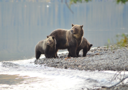

In [11]:
im = Image.open(dest)
im.to_thumb(128,128)

Now, download all url for given terms

In [12]:
bear_types='grizzly', 'black', 'teddy'

# create folder
path=Path('bears')

In [13]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

now, verify that we have the files

In [15]:
fns=get_image_files(path)

#remove failed images
failed = verify_images(fns)
failed.map(Path.unlink)

fns

(#564) [Path('bears/teddy/7d7da85c-b0f2-407f-8ede-c738ed73d911.jpg'),Path('bears/teddy/29b9cf18-4f7d-4973-8ff0-1269d5951d1b.jpg'),Path('bears/teddy/23f8eda0-4e28-4f08-9e4c-b8906f2bb7c5.jpg'),Path('bears/teddy/a01a0d13-b3e0-416f-b531-e6aebae754ee.jpg'),Path('bears/teddy/8f2b03ac-33c6-4db3-8a9b-5821023619d7.jpg'),Path('bears/teddy/8797d944-9d0a-4a8f-90d4-5019a7240f48.jpg'),Path('bears/teddy/b4d4092c-2d50-43fd-9f94-0af6adaa2b89.JPG'),Path('bears/teddy/3616948f-ac02-48e3-b6dc-1f962052e17e.jpg'),Path('bears/teddy/95e6a339-1fd6-4a78-b8e5-9c2f19822095.jpeg'),Path('bears/teddy/9e68778c-701c-4f40-b5cf-d9b44f42dae9.jpg')...]

## Getting Help in Jupyter Notebooks

In [ ]:
## ??verify_images
# will show ho argument, function, file, type and return value to function

## DATALOADERS

these allow us to have data available for train anf validation when needed

In [16]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

What kinds of data we are working with
How to get the list of items
How to label these items
How to create the validation set

In [17]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [18]:
dls=bears.dataloaders(path)

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


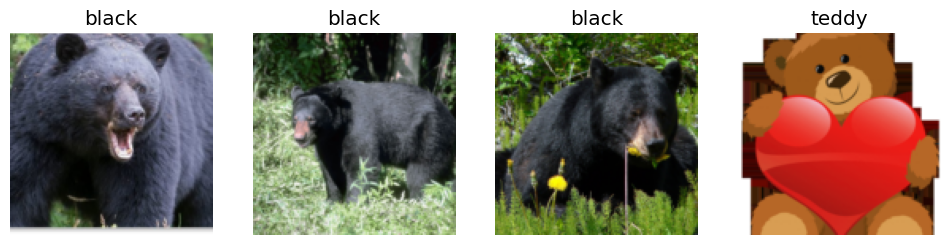

In [19]:
dls.valid.show_batch(max_n=4, nrows=1)

By default Resize crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them: However with this, we might loose important features.

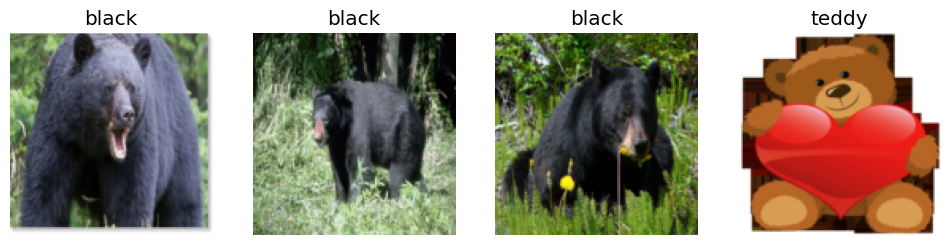

In [20]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

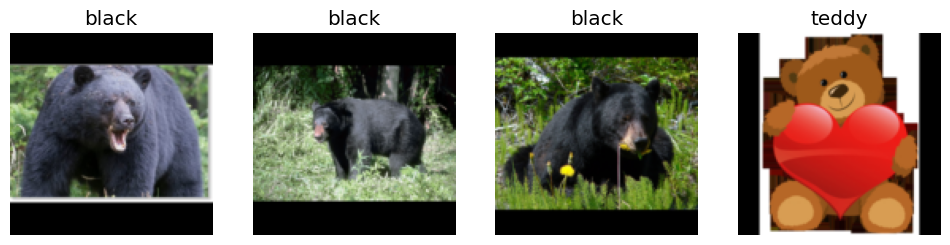

In [21]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

to solve this, we can set limits

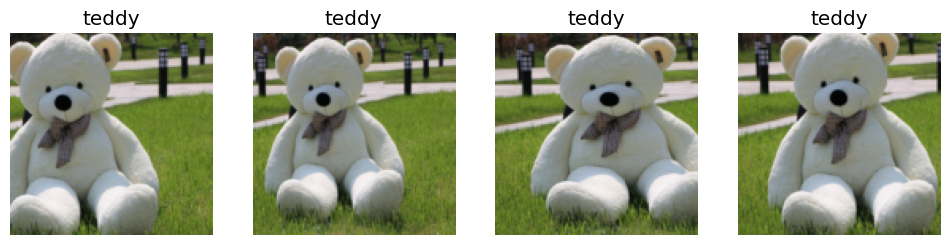

In [25]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data augmentation

creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes.

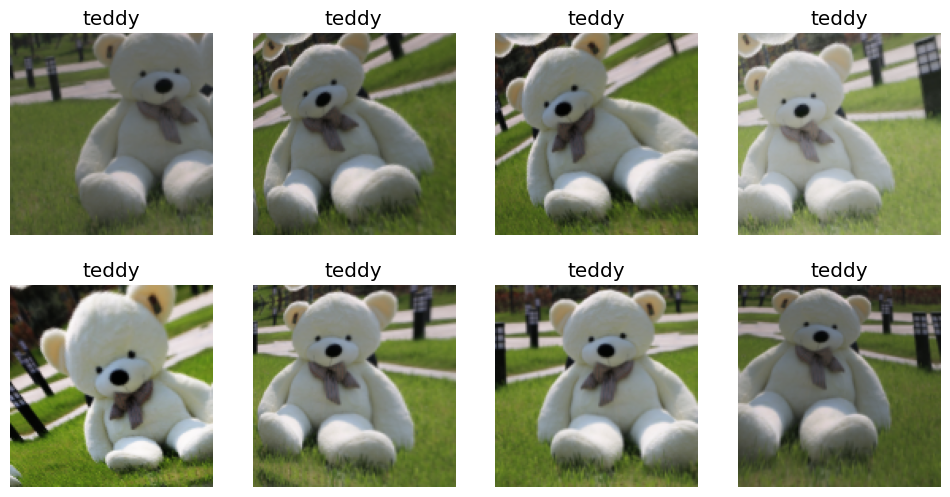

In [26]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Training model, and using it to clean data

In [ ]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [27]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


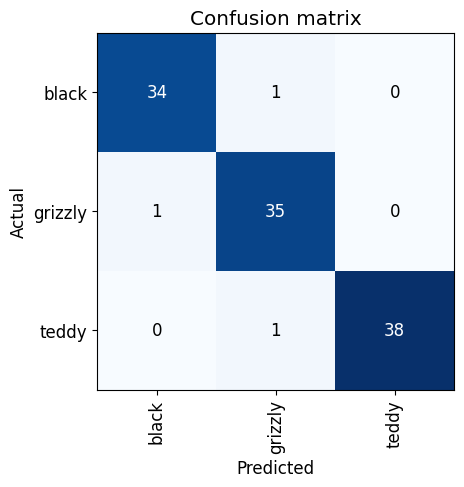

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [29]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

## Turning Model into an Online Application

Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the architecture and the trained parameters.

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

The downside is that we have to use this same path the model was saved in

In [32]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict('images/grizzly.jpg')

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('grizzly', tensor(1), tensor([4.8960e-04, 9.9906e-01, 4.5269e-04]))

We can get stored list of all possible categories

In [35]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

## Creating Notebook App

To use our model in an application, we can simply treat the predict method as a regular function. Therefore, creating an app from the model can be done using any of the myriad of frameworks and techniques available to application developers.

However, most data scientists are not familiar with the world of web application development. So let's try using something that you do, at this point, know: it turns out that we can create a complete working web application using nothing but Jupyter notebooks! The two things we need to make this happen are:

IPython widgets (ipywidgets)
Voilà
IPython widgets are GUI components that bring together JavaScript and Python functionality in a web browser, and can be created and used within a Jupyter notebook. For instance, the image cleaner that we saw earlier in this chapter is entirely written with IPython widgets. However, we don't want to require users of our application to run Jupyter themselves.

That is why Voilà exists. It is a system for making applications consisting of IPython widgets available to end users, without them having to use Jupyter at all. Voilà is taking advantage of the fact that a notebook already is a kind of web application, just a rather complex one that depends on another web application: Jupyter itself. Essentially, it helps us automatically convert the complex web application we've already implicitly made (the notebook) into a simpler, easier-to-deploy web application, which functions like a normal web application rather than like a notebook.

But we still have the advantage of developing in a notebook, so with ipywidgets, we can build up our GUI step by step. We will use this approach to create a simple image classifier. First, we need a file upload widget:

In [36]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [37]:
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [38]:
img = PILImage.create(btn_upload.data[-1])

In [39]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [40]:
pred,pred_idx,probs = learn_inf.predict(img)

In [41]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9991')

Make a button to do the classification. It need to look exactly like the upload button:

In [42]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [43]:
# click handler

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [44]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [46]:
#hide_output
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])

In [48]:
#hide_output
# now the Real app
!pip install voila
!jupyter serverextension enable --sys-prefix voila

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.5.5 OK


## Deployment

- As we've seen, GPUs are only useful when they do lots of identical work in parallel. If you're doing (say) image classification, then you'll normally be classifying just one user's image at a time, and there isn't normally enough work to do in a single image to keep a GPU busy for long enough for it to be very efficient. So, a CPU will often be more cost-effective.

- An alternative could be to wait for a few users to submit their images, and then batch them up and process them all at once on a GPU. But then you're asking your users to wait, rather than getting answers straight away! And you need a high-volume site for this to be workable. If you do need this functionality, you can use a tool such as Microsoft's [ONNX Runtime](https://github.com/microsoft/onnxruntime), or [AWS Sagemaker](https://aws.amazon.com/sagemaker/)

- The complexities of dealing with GPU inference are significant. In particular, the GPU's memory will need careful manual management, and you'll need a careful queueing system to ensure you only process one batch at a time.
There's a lot

For at least the initial prototype of your application, and for any hobby projects that you want to show off, you can easily host them for free. The best place and the best way to do this will vary over time, so check the book's website for the most up-to-date recommendations. As we're writing this book in early 2020 the simplest (and free!) approach is to use Binder. To publish your web app on Binder, you follow these steps:

1. Add your notebook to a GitHub repository.
2. Paste the URL of that repo into Binder's URL, as shown in <>.
3. Change the File dropdown to instead select URL.
4. In the "URL to open" field, enter `/voila/render/name.ipynb` (replacing `name` with the name of for your notebook).
5. Click the clickboard button at the bottom right to copy the URL and paste it somewhere safe.
6. Click Launch.

## Practical considerations
for example bear detection in park

- Working with video data instead of images
- Handling nighttime images, which may not appear in this dataset
- Dealing with low-resolution camera images
- Ensuring results are returned fast enough to be useful in practice
- Recognizing bears in positions that are rarely seen in photos that people post online (for example from behind, partially covered by bushes, or when a long way away from the camera)